# MPG Prediction

#### Import Libraries and Loading Data

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

In [277]:
df = pd.read_csv('mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


#### Let's see the meaning of the columns of the data
* mpg - Milieage/Miles Per Galon
* cylinders - the power unit of the car where gasoline is turned into power
* displacement - engine displacement of the car
* horsepower - rate of the engine performance
* weight - the weight of a car
* acceleration - the acceleration of a car
* model_year - model year of the car
* origin - the origin of the car 
* name - the name of the car

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [279]:
# Check missing value
df.isna().sum() 

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [280]:
# Display data that has a missing value in the `horsepower` column
df[df['horsepower'].isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


In [281]:
# let's try to see what the odd value is in the horsepower column
df.horsepower.unique()

array([130., 165., 150., 140., 198., 220., 215., 225., 190., 170., 160.,
        95.,  97.,  85.,  88.,  46.,  87.,  90., 113., 200., 210., 193.,
        nan, 100., 105., 175., 153., 180., 110.,  72.,  86.,  70.,  76.,
        65.,  69.,  60.,  80.,  54., 208., 155., 112.,  92., 145., 137.,
       158., 167.,  94., 107., 230.,  49.,  75.,  91., 122.,  67.,  83.,
        78.,  52.,  61.,  93., 148., 129.,  96.,  71.,  98., 115.,  53.,
        81.,  79., 120., 152., 102., 108.,  68.,  58., 149.,  89.,  63.,
        48.,  66., 139., 103., 125., 133., 138., 135., 142.,  77.,  62.,
       132.,  84.,  64.,  74., 116.,  82.])

In [282]:
# Find average `horsepower` by car origin
df.groupby('origin').mean()['horsepower']

origin
europe     80.558824
japan      79.835443
usa       119.048980
Name: horsepower, dtype: float64

In [283]:
# Using the average horsepower based on the origin of the car to fill in the missing value in mpg
df['horsepower'] = df.groupby('origin')['horsepower'].apply(lambda x:round(x.fillna(x.mean())))

In [284]:
df.horsepower = df.horsepower.astype(int)

# print the info of the data again to see the datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    int32  
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(3), int32(1), int64(3), object(2)
memory usage: 26.6+ KB


In [285]:
# won't be needing the name and origin column so we drop it
df = df.drop(['name', 'origin'],axis=1)

# check for duplicates and null values
print('sum of duplicated values: {}\n'.format(df.duplicated().sum()))
print('sum of null values: {}'.format(df.isnull().sum()))

sum of duplicated values: 0

sum of null values: mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
dtype: int64


In [286]:
# let's print the summary statistics of the data
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.497487,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,38.263290,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,94.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


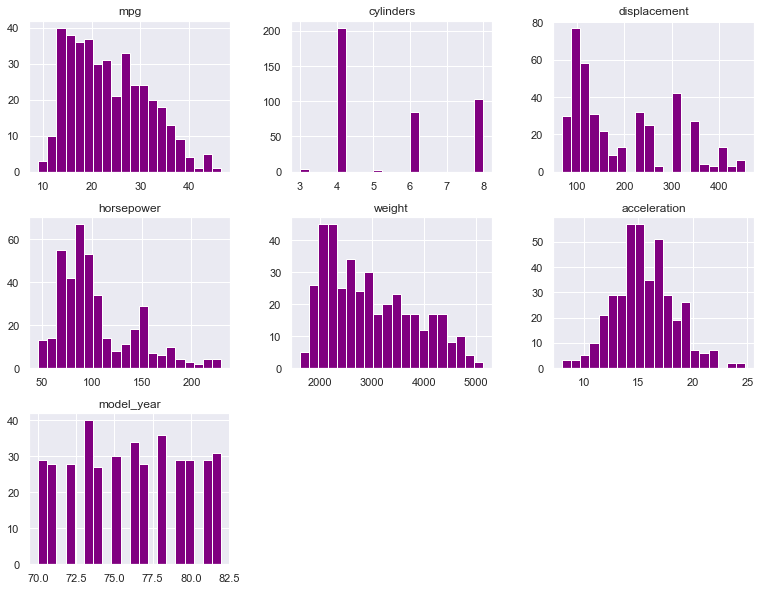

In [287]:
# let's visualize the distribution of the features of the cars
df.hist(figsize=(13,10),bins=20,color='purple')
plt.show()

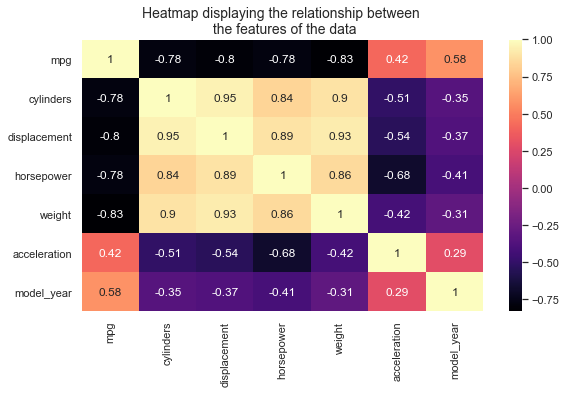

In [288]:
# Let's visualize the relationships between the Mileage Per Galon(mpg) of a car and the other features
plt.figure(figsize=(9,5))
sns.heatmap(df.corr(), cmap=plt.cm.magma, annot=True)
plt.title('Heatmap displaying the relationship between \n the features of the data', fontsize=14)
plt.show()

In [289]:
# We can also check for multicollinearity using the variance inflation factor.
# A variable/feature affected by multicollinearity will have a value greater than 5....
# ... when we print out the series from the variance inflation factor
# We will have to do a feature selection to get rid of the multicollinearity.

X1 = sm.tools.add_constant(df) 

series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],
                  index=X1.columns)

# Let's drop the columns that highly correlate with each other
newdf = df.drop(['cylinders','displacement','weight'], axis=1)

# Let's do the variance inflation factor method again after doing a feature selection 
# ... to see if there's still multicollinearity.
X2 = sm.tools.add_constant(newdf)

series2 = pd.Series([variance_inflation_factor(X2.values,i) for i in range(X2.shape[1])], index=X2.columns)

print('Series before feature selection: \n\n{}\n'.format(series1))
print('Series after feature selection: \n\n{}'.format(series2))

Series before feature selection: 

const           756.681456
mpg               5.227911
cylinders        10.622875
displacement     19.790230
horsepower        8.578896
weight           13.354005
acceleration      2.478302
model_year        1.905828
dtype: float64

Series after feature selection: 

const           678.475140
mpg               3.391184
horsepower        4.162981
acceleration      2.009709
model_year        1.539035
dtype: float64


In [290]:
# print the correlation between the mpg and the remaining variables
print('Correlation between mpg and the remaining variables:\n\n{}'.format(newdf.corr().mpg))

Correlation between mpg and the remaining variables:

mpg             1.000000
horsepower     -0.775931
acceleration    0.420289
model_year      0.579267
Name: mpg, dtype: float64


In [291]:
X = newdf.drop('mpg',axis=1)  # create a DataFrame of feature/independent variables
y = newdf.mpg   # create a series of the dependent variable

# the feature/independent variables are not of the same scale so we scale them 
# this is only neccessary for the LinearRegression, Ridge and Lasso models
# scaling the feature variables ensures fast computing.
X_scaled = preprocessing.scale(X)

# preprocessing.scale() returns a 2-d array not a DataFrame so we make our scaled variables
# a DataFrame.
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# split our data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=0)

model = LinearRegression()  # initialize the LinearRegression model
model.fit(X_train, y_train)  # we fit the model with the training data

LinearRegression()

In [292]:
linear_pred = model.predict(X_test)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(model.score(X_train,y_train)))
# score the model on the test set
print('Test score: {}\n'.format(model.score(X_test,y_test)))
# calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test,linear_pred)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,linear_pred)))

Train score: 0.7115483689853398

Test score: 0.6845750711411973

Overall model accuracy: 0.6845750711411973

Mean Squared Error: 20.156246785315087


In [293]:
# let's fit a ridge regression model and see if we can get a higher accuracy
ridge = Ridge(alpha=.01)
ridge.fit(X_train,y_train)  # fit the model with the training data

ridge_pred = ridge.predict(X_test)  # make predictions

# score the model to check the accuracy
print('Train score: {}\n'.format(ridge.score(X_train,y_train)))
print('Test score: {}\n'.format(ridge.score(X_test,y_test)))
print('Overall model accuracy: {}\n'.format(r2_score(y_test,ridge_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,ridge_pred)))

Train score: 0.7115483669332534

Test score: 0.6845732450363285

Overall model accuracy: 0.6845732450363285

Mean Squared Error: 20.156363476854096


In [294]:
# we now try to tune the parameters of the ridge model for a better accuracy
# we use a grid search to find the best parameters for the ridge model
ridge_model = Ridge()

param = {'alpha':[0,0.1,0.01,0.001,1]}  # define the parameters

# initialize the grid search
ridge_search = GridSearchCV(ridge_model,param,cv=5,n_jobs=-1)

ridge_search.fit(X_train,y_train)   # fit the model 

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.01, 0.001, 1]})

In [295]:
# print out the best parameter for ridge and score it on the test and train data

print('Best parameter found:\n{}'.format(ridge_search.best_params_))
print('Train score: {}\n'.format(ridge_search.score(X_train,y_train)))
print('Test score: {}'.format(ridge_search.score(X_test,y_test)))

Best parameter found:
{'alpha': 1}
Train score: 0.7115282723911472

Test score: 0.6843776312677601


In [296]:
# let's try and fit a Lasso model for the regression
# here, we just move on to making the grid search and find the best parameters
lasso = Lasso()

param['max_iter'] = [1000,10000,100000,1000000]

lasso_search = GridSearchCV(lasso,param,cv=5,n_jobs=-1) # initialize the grid search

lasso_search.fit(X_train,y_train)  # fit the model

# print out the best parameters and score it 
print('Best parameter found:\n{}\n'.format(lasso_search.best_params_))
print('Train score: {}\n'.format(lasso_search.score(X_train,y_train)))
print('Test score: {}'.format(lasso_search.score(X_test,y_test)))

Best parameter found:
{'alpha': 0, 'max_iter': 10000}

Train score: 0.7115483689853399

Test score: 0.6845750711411971


In [297]:
# we move on to using the ensemble methods for the regression
# split the unscaled/original X and y data into training and testing data
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

In [298]:
dtree = DecisionTreeRegressor() # initialize a DecisionTreeRegressor model

params = {'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_depth':[2,3,4,5,6,7]}                # define the hyperparameters

tree_search = GridSearchCV(dtree,params,cv=5,n_jobs=-1)  # initialize the grid search

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]})

In [299]:
tree_pred = tree_search.predict(xtest)  # make predictions with the model

# print out the best parameters found and score the model
print('Best parameter found:\n{}\n'.format(tree_search.best_params_))
print('Train score: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Test score: {}\n'.format(tree_search.score(xtest,ytest)))
print('Overall model accuracy: {}\n'.format(r2_score(ytest,tree_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(ytest,tree_pred)))

Best parameter found:
{'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 2}

Train score: 0.8688282670997546

Test score: 0.7643809660364884

Overall model accuracy: 0.7643809660364884

Mean Squared Error: 11.721457523945052


In [300]:
# we now fit a RandomForestRegressor model and perform a grid search to find the best 
# parameters
forest = RandomForestRegressor()

# we add the n_estimators parameter in our previous parameter dictionary
params['n_estimators'] = [100,200,300,400,500]

forest_search = RandomizedSearchCV(forest,params,cv=5,n_jobs=-1,     # initialize the search
                                  n_iter=50)

forest_search.fit(xtrain,ytrain)  # fit the model

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})

In [301]:
forest_pred = forest_search.predict(xtest)  # make prediction with the model

# print out the best parameters and score the model
print('Best parameter found:\n{}\n'.format(forest_search.best_params_))
print('Train score: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Test score: {}\n'.format(forest_search.score(xtest,ytest)))
print('Overall model accuracy: {}\n'.format(r2_score(ytest,forest_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(ytest,forest_pred)))

Best parameter found:
{'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 6}

Train score: 0.8935516556544307

Test score: 0.837107629707528

Overall model accuracy: 0.837107629707528

Mean Squared Error: 8.103487936605422


In [302]:
# train a GradientBoostingRegressor model

gradient_model = GradientBoostingRegressor()  # instantiate the model

# append a learning_rate parameter to the parameter dictionary
params['learning_rate'] = [0.05,0.1,0.2,0.3,0.4,0.5]

gradient_search = RandomizedSearchCV(gradient_model,params,cv=5,n_jobs=-1,
                                  n_iter=50)   # initialize the search

gradient_search.fit(xtrain,ytrain)   # fit the model

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})

In [303]:
gradient_pred = gradient_search.predict(xtest)  # make predictions with the model

# print out the best parameters and score the model
print('Best parameter found:\n{}\n'.format(gradient_search.best_params_))
print('Train score: {}\n'.format(gradient_search.score(xtrain,ytrain)))
print('Test score: {}\n'.format(gradient_search.score(xtest,ytest)))
print('Overall model accuracy: {}\n'.format(r2_score(ytest,gradient_pred)))
print('Mean Squared Error: {}\n'.format(mean_squared_error(ytest,gradient_pred)))
print('Looks like this model is not too overfitted and it has low mean squared error \
so we use this one........')

Best parameter found:
{'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 2, 'learning_rate': 0.05}

Train score: 0.9048944607636578

Test score: 0.8224313588578405

Overall model accuracy: 0.8224313588578405

Mean Squared Error: 8.83359569776858

Looks like this model is not too overfitted and it has low mean squared error so we use this one........


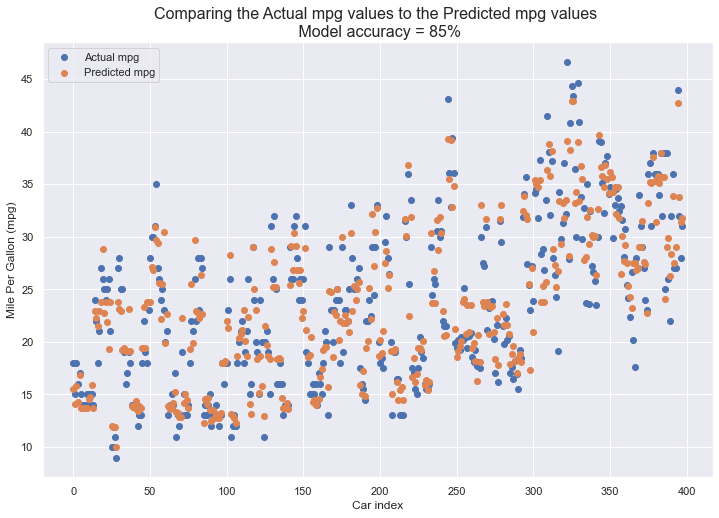

In [304]:
# we will now try to make predictions and see how well our model predicts
# we will visualize the actual mpg values recorded and the mpg values predicted by our 
# model to see how close our predictions are to the actual values.

newdf_new = newdf.drop('mpg',axis=1)  # create a new DataFrame of the feature variables

# make a DataFrame of the actual mpg and the predicted mpg 
data = pd.DataFrame({'Actual mpg':newdf.mpg.values,
                    'Predicted mpg':gradient_search.predict(newdf_new.values)})


# make a scatter plot of the actual and the predicted mpg of a car
plt.figure(figsize=(12,8))
plt.scatter(data.index,data['Actual mpg'].values,label='Actual mpg')
plt.scatter(data.index,data['Predicted mpg'].values,label='Predicted mpg')
plt.title('Comparing the Actual mpg values to the Predicted mpg values \n Model accuracy = 85%', fontsize=16)
plt.xlabel('Car index')
plt.ylabel('Mile Per Gallon (mpg)')
plt.legend(loc='upper left')
plt.show()

**We can see from the above scatter plot that our model made a good predictions
   as the values of the actual mpg and the predicted mpg are very close to each
   other.
   We can confidently say that we have succeeded in training a model that predicts 
   the Mileage Per Gallon (mpg) of a car given the acceleration, model, and 
   the horsepower of a car.**